### 向量库检索 or web 检索 agen
- [x] 定制 CustomRetriever 类，接收 vectorstore 和 k 参数，实现多查询重排功能，llm生成的结果异常捕获，使用一次llm。  - [ ] 用llm对问题进行抽象
- [x] 文档预处理和向量化
- [ ] 检索prompt研究
- [x] 开发api, use fastapi
- [ ] 返回生成器对象
- [ ] 制作多个性化聊天智能体
- [ ] 拥有代码执行能力的智能体/目前没用
- [ ] 多情景多轮对话
- [ ] 多情感
- [ ] prompt

In [23]:
import os
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_nomic.embeddings import NomicEmbeddings
from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers import StrOutputParser, ListOutputParser
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents import Document
from langchain_core.callbacks import CallbackManagerForRetrieverRun
from typing import List,Any, Dict

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import chain
llm2json = ChatOllama(model="qwen:7b", format="json", temperature=0)
llm2str = ChatOllama(model="qwen2:7b", temperature=0)
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]="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"
os.environ["LANGCHAIN_PROJECT"]="pr-sunny-icicle-8"
os.environ["TAVILY_API_KEY"] = "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"
local_llm = "qwen2:7b"

In [10]:
prompt_multi_query = PromptTemplate(
    input_variables=["question"],
    template="""
    * 你是一个问题要素提取并重写问题的助手，主要将原问题重写成4个新问题并用于检索\n
    * 你的任务流程是：\
    1. 提取用户问题的主题和焦点、目的和意图、事件和行动。返回的key为"主题"、"焦点"、"目的"、"意图"、"事件"和"行动"。\
    2. 对问题进行4次重写，要求这4个问题与原问题的相似度尽量高。返回的Key为"问题组",value为list，lists包含4个重写后的新问题\
    3. 输出一个json格式的字符串，格式为"问题组":["新问题1","新问题2","新问题3","新问题4"],"主题":"主题","焦点":"焦点","目的":"目的","意图":"意图","事件":"事件","行动":"行动"\



    * 以下是需要重写的原问题:

    {question}
    """,)

question_rewriter = prompt_multi_query | llm2json | JsonOutputParser()

question_rewriter.invoke("一项RAG技术的整个技术流程是什么？")

{'问题组': ['详细列出RAG技术的技术流程步骤',
  'RAG技术的整体工艺过程具体包括哪些环节?',
  '想知道RAG技术从设计到完成的所有技术操作步骤',
  'RAG技术的完整技术流程是怎样的，能提供一份详细的清单吗?'],
 '主题': 'RAG技术技术流程',
 '焦点': '整个流程和步骤',
 '目的': '获取详细流程信息',
 '意图': '理解并记录技术流程',
 '事件': '学习和技术应用',
 '行动': '查找、阅读和总结流程'}

In [32]:
# 重写查询检索器
from langchain.retrievers.self_query.base import SelfQueryRetriever
class CustomRetriever(BaseRetriever):
    vectorstore: Any  # 假设 vectorstore 是任意类型，实际类型应根据你的需要来定义
    k: int
    question_rewriter: Any  # 同样，这里的 Any 应该替换为实际的类型

    def _get_relevant_documents(self, query: str) -> List[Document]:
        """
        Get documents relevant to the query and add score information.

        Args:
            query (str): The search query.

        Returns:
            List[Document]: List of documents with updated scores.
        """
        fused_scores = {}  # Document scores will be accumulated here

        # Generate multiple queries using question_rewriter
        query_dict = self._get_query_dict(query)

        query_list = [query] + query_dict.get("问题组", [])

        for q in query_list:
            docs, scores = zip(*self.vectorstore.similarity_search_with_score(q, k=3))

            for doc, score in zip(docs, scores):
                doc.metadata["score"] = score

            self._update_fused_scores(docs, scores, fused_scores)

        # Re-rank documents based on the new scores
        reranked_results = self._get_reranked_results(fused_scores)
        return reranked_results[:self.k*2]

    def _get_query_dict(self, query: str) -> Dict[str, Any]:
        """Generate query dictionary and handle potential errors."""
        try:
            query_dict = self.question_rewriter.invoke(query)
            if not isinstance(query_dict, dict) or "问题组" not in query_dict or not isinstance(query_dict["问题组"], list):
                raise ValueError("Invalid query_dict format")
            return query_dict
        except (KeyError, ValueError) as e:
            print(f"Error: {e}")
            return {"问题组": []}

    def _update_fused_scores(self, docs: List[Document], scores: List[float], fused_scores: Dict[str, Dict[str, float]]):
        """Update fused scores based on document scores and ranking."""
        doc_scores = {doc.page_content: doc.metadata for doc in docs}
        
        for rank, (doc, score) in enumerate(sorted(doc_scores.items(), key=lambda x: x[1]["score"], reverse=True)):
            if doc not in fused_scores:
                fused_scores[doc] = score
                fused_scores[doc]["score"] = 0
            fused_scores[doc]["score"] += 1.0 / (rank + 60)
            print(fused_scores[doc]["score"])

    def _get_reranked_results(self, fused_scores: Dict[str, Dict[str, float]]) -> List[Document]:
        """Re-rank documents based on the new scores."""
        return [Document(metadata=score, page_content=doc) for doc, score in
                sorted(fused_scores.items(), key=lambda x: x[1]["score"], reverse=True)]


In [ ]:
## 检索可替换
urls = [
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]
import ollama
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
print(docs_list)
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)
print(doc_splits)
# Debug the embedding object
from langchain_ollama import OllamaEmbeddings

embedding = OllamaEmbeddings(model="nomic-embed-text:v1.5")
print(type(embedding))  # Check the type of the embedding object
print(embedding)  # Print the embedding object to see its structure

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embedding,  # Ensure embedding is correct
)


In [33]:
retriever = CustomRetriever(
    vectorstore=vectorstore,
    k=3,
    question_rewriter = question_rewriter
)

result = retriever.invoke("dinosaur movie with rating less than 8")
print(result)

0.016666666666666666
0.016666666666666666
0.016666666666666666
0.016666666666666666
0.016666666666666666
[Document(metadata={'description': 'The use of large language models in the real world has strongly accelerated by the launch of ChatGPT. We (including my team at OpenAI, shoutout to them) have invested a lot of effort to build default safe behavior into the model during the alignment process (e.g. via RLHF). However, adversarial attacks or jailbreak prompts could potentially trigger the model to output something undesired.\nA large body of ground work on adversarial attacks is on images, and differently it operates in the continuous, high-dimensional space.', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/', 'title': "Adversarial Attacks on LLMs | Lil'Log", 'score': 0.016666666666666666}, page_content='Fig. 13. UI for humans to do tool-assisted adversarial attack on a classifier. Humans are asked to edit the prompt or completion to lower t

In [62]:
# 判断问题是否需要进行问题检索
# 目前prompt合理，
'''
# tool 1：determine whether the qwen：7b can answer the question.
qwen: 7b is a small llm, you can use 72b to answer the question.
'''

prompt_judege_retrieval = PromptTemplate(
    input_variables=["question"],
    template="""
    如果你不知道或者不确定如何回答，直接回答"no"。如果你知道如何回答，请回答yes。


    问题：


    {question}
    """,)

judge_retrieval_chain = prompt_judege_retrieval | llm2str | StrOutputParser() | (lambda s: 'no' if 'no' in s.lower() else 'yes')
# print((judge_retrieval_chain.invoke("我叫什么名字")))


In [96]:
### 强大的llm用于回答问题

# 构建检索用的prompt
prompt_retrieve_augmented = PromptTemplate(
    template="""
    你是一个检索增加机器人，你要基于检索的知识库来回答用户问题。\n\n

    以下是检索到的知识：

    {retrieved_knowledge}\n\n

    用户问题：

    {question}
    """,
    input_variables=["retrieved_knowledge","question"],
)
# 构建对话用的prompt
def format_dialog(conversation:list) -> str:
    '''
    将langchain的message转化成我想要的message

    args:
        conversation: list[Message] example: {"question":[HumanMessage,AIMessage]}
    retrun : str
        exapmle:
            "你是一个AI助手，\n\n\n以下是用户和助手的对话：\n\n
            用户：你好\n\n
            助手：你好，有什么可以帮你的吗？\n\n
            以下是用户问题。\n\n
            用户：我想知道如何使用langchain"
    raises:
        TypeError: 如果 `conversation` 不是字典类型或缺少 'question' 键。
        ValueError: 如果 'question' 键的值不是列表类型。
        TypeError: 如果 'question' 列表中包含非 HumanMessage 或 AIMessage 实例。
    '''

        # 输入检查
    if not isinstance(conversation, dict):
        raise TypeError("输入参数 `conversation` 必须是一个字典。")
    
    if 'question' not in conversation:
        raise KeyError("字典中缺少 'question' 键。")
    
    if not isinstance(conversation['question'], list):
        raise ValueError("'question' 键的值必须是一个列表。")
    
    # 处理对话列表
    dialog_list = conversation['question']
    if not all(isinstance(message, (HumanMessage, AIMessage)) for message in dialog_list):
        raise TypeError("'question' 列表中的每个元素必须是 HumanMessage 或 AIMessage 实例。")
    
    conversation = conversation['question']
    formatted_dialog = ["你是一个AI助手，\n\n\n以下是用户和助手的对话："]

    question = conversation.pop(-1)

    for message in conversation:
        if isinstance(message, HumanMessage):
            formatted_dialog.append(f"用户：{message.content}")
        elif isinstance(message, AIMessage):
            formatted_dialog.append(f"助手：{message.content}\n\n")
            
    formatted_dialog.append(f"以下是用户问题。\n\n用户：{question.content}")
    return "\n".join(formatted_dialog)


# 构建回答用的prompt
prompt_answer_question = PromptTemplate(
    template="""
    {question}。
    """,
    input_variables=["question"],
)

power_bot_retrieved_knowledge = prompt_retrieve_augmented | llm2str | StrOutputParser()
power_bot_answer_question = format_dialog | prompt_answer_question | llm2str | StrOutputParser()


TypeError: list indices must be integers or slices, not str

In [64]:
### 向量库检索文档

question = "hello"
docs = retriever.get_relevant_documents(question)

/usr/local/anaconda3/envs/ChatTTS/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [65]:
### web检索文档


web_search_tool = TavilySearchResults(k=3)

In [66]:
### 文档评分，后续可换计算公式，目前用llm判断
prompt_doc_grade = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt_doc_grade | llm2json | JsonOutputParser()



In [67]:
### 路由网页搜索 or rewrite question。目前用llm来判断上下文与问题的相关度，有低中高。
prompt_router = PromptTemplate(
    template="""你是一个专家，需要你来判断用户给出的问题是否与提供的文档相关。\n
    这里是文档。\n
    {context} \n
    需要你返回相关度标准，如果相关度高则返回high，如果相关度中等则返回medium，如果相关度低则返回low。 \n
    Return the a JSON with a single key 'relevance' and no premable or explanation. value only one of the high,medium,low\n
    这是用户给出的问题:\n 
    {question}""",
    input_variables=["context","question"],
)

question_router = prompt_router | llm2json | JsonOutputParser()


In [68]:
### Question Re-writer

# LLM

# Prompt
re_write_prompt = PromptTemplate(
    template="""You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the initial and formulate an improved question. \n
     Here is the initial question: \n\n {question}. Improved question with no preamble: \n """,
    input_variables=["question"],
)

question_rewriter = re_write_prompt | llm2str | StrOutputParser()


# graph state

In [69]:


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    messages: Annotated[list, add_messages]
    documents: List[str]

In [105]:
### Nodes
def power_bot(state):
    """
    Power bot: Powerful llm to Answer question directly
    
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation 
    """
    print("---POWER BOT ANSWERING---")
    question = state["messages"]
    documents = state["documents"]
    if documents:
        print("---DOCUMENTS FOUND---")
        generation = power_bot_retrieved_knowledge.invoke({"context": documents,"question": question})
    else: 
        print("---NO DOCUMENTS FOUND---")
        generation = power_bot_answer_question.invoke({"question": question})
    return {"documents": documents, "messages": AIMessage(content = generation)}

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["messages"][-1]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents}




def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["messages"][-1]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["messages"][-1]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    # state["message"][-1] = better_question
    return {"documents": documents, "messages": better_question}

def web_search (state):
    """
    Web search to find documents.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---WEB SEARCH---")
    # question = state["question"]
    # print(question)
    # documents = web_search_tool.invoke({"query": question})
    # print(documents)
    # web_results = '\n'.join([d["content"] for d in documents])
    # web_results = Doucument(page_content=web_results)
    from langchain.schema import Document
    question = state["question"]
    print(question)
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    return {"documents": web_results}

### Edges
def judge_retrieval(state):
    """
    Determines whether to route question to derectly answer or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    print("---JUDGE QUESTION---")
    question = state["messages"]
    if judge_retrieval_chain.invoke({"question": question})== "yes":
        print("---JUDGE: QUESTION IS DIRECTLY ANSWERABLE---")
        return "power_bot"
    else:
        print("---JUDGE: QUESTION IS NOT DIRECTLY ANSWERABLE---")
        return "power_bot"

def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["messages"][-1]
    documents = state["documents"]
    source = question_router.invoke({"context": documents, "question": question})
    print(documents)
    print(question)
    print(source)
    print(source["relevance"])
    if source["relevance"] == "low":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source["relevance"] == "medium":
        print("---ROUTE QUESTION TO rewrite question---")
        return "rewrite"
    elif source["relevance"] == "high":
        print("---ROUTE TO ANSWER THE QUESTION---")
        return "power_bot"


In [86]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")
config = {"configurable": {"thread_id": "1"}}

In [106]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("power_bot", power_bot)
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("web_search", web_search)
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
#workflow.add_edge(START, "retrieve")
workflow.add_edge("power_bot",END)
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    START,
    judge_retrieval,
    {
        "power_bot": "power_bot",
        "vectorstore": "retrieve",
    },
)
workflow.add_conditional_edges(
    "grade_documents",
    route_question,
    {
        "web_search": "web_search",
        "rewrite": "transform_query",
        "power_bot": "power_bot",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_edge("web_search", "power_bot")

# Compile
app = workflow.compile(checkpointer=memory)

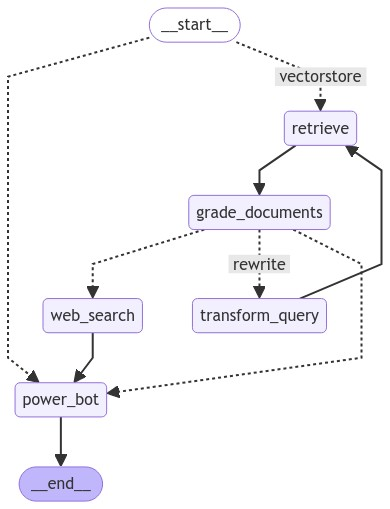

In [73]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print("out")
    pass

In [107]:

# Run
user_input = "你还记得我是谁吗"
inputs = {"messages": [HumanMessage(content = user_input)]}
for output in app.stream(inputs,{"configurable": {"thread_id": "114"}}, stream_mode="values"):
    print(output["messages"][-1])
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
# print((output))

---JUDGE QUESTION---
---JUDGE: QUESTION IS NOT DIRECTLY ANSWERABLE---
content='你还记得我是谁吗' id='da068479-a560-4984-8adb-9ad86ee42a52'
'\n---\n'
---POWER BOT ANSWERING---
---NO DOCUMENTS FOUND---
[HumanMessage(content='你还记得我是谁吗', id='76a3c3c7-b27b-4530-a1a2-e85693bbd974'), HumanMessage(content='你还记得我是谁吗', id='794145a9-bad9-4b9f-b562-8a19cc0f24ab'), HumanMessage(content='你还记得我是谁吗', id='2225c896-bb15-4966-a072-a00f7701a349'), HumanMessage(content='你还记得我是谁吗', id='6578f5bb-d39d-42ff-a4af-1921b9f4a2bd'), AIMessage(content='我作为一个AI助手，并没有个人记忆，所以我无法记住特定的人或对话。不过我可以根据当前的输入来提供帮助和解答问题。您需要什么方面的帮助呢？', id='6c4d62e1-a346-4d56-8db4-8309d8d3e987'), AIMessage(content='我作为一个AI助手，并没有个人记忆，所以无法记住特定的人或对话。但我可以继续为您提供帮助和解答您的问题。请问您有什么需要了解或者想要解决的问题呢？', id='8a8fc39d-495f-4cf1-a5d6-0012b34786e5'), AIMessage(content='我作为一个AI助手，并没有个人记忆，所以我无法记住特定的人或对话。不过我可以根据当前的输入来提供帮助和解答问题。如果您有具体的问题需要解答，请告诉我，我会尽力为您提供帮助。您需要了解什么方面的信息呢？', id='aaeedbf0-1d5b-47ac-b933-34b7efa68e27'), AIMessage(content='我作为一个AI助手，并没有个人记忆，所以我无法记住特定的人或对话。不过我可以根据当

In [ ]:
from fastapi import FastAPI
import uvicorn

app = FastAPI()

@app.get("/")
def llm(query: str = None,uuid: str = None):
    inputs = {"messages": [HumanMessage(content = query)]}

    for output in app.stream(inputs,{"configurable": {"thread_id": uuid}}, stream_mode="values"):
        print(output["messages"][-1])

    # return EventSourceResponse(generator, media_type="text/event-steam") # 返回生成器，待实现
    return output["messages"][-1]


if __name__ == "__main__":
    uvicorn.run(app, host="127.0.0.1", port=8000, reload=True)


In [ ]:
print((output))

{'messages': [HumanMessage(content='Hi there! My name is Will.', id='75b3257d-e09f-47f4-aeba-8898e69c3d8a'), HumanMessage(content='Hello, Will! Nice to meet you. How can I assist you today?', id='02f85ebc-6519-48c6-8372-713d06e21cc0'), HumanMessage(content='Hi there! My name is Will.', id='3ca51a38-00cc-4596-bb94-53e39d353122'), HumanMessage(content='你好！很高兴遇见你，Will。我是这里的专家，有什么我可以帮助你的吗？', id='c3efbfa5-0159-4d93-8dc9-9dc9bec39e63'), HumanMessage(content='Hi there! My name is Will.', id='be1f8bf1-d618-4076-84da-63daeee9a175'), HumanMessage(content='你好！Will，很高兴遇见你。我是这里的专家，有什么我可以帮助你的吗？请告诉我你的需求或者你想了解的问题，我会尽力提供最合适的解答和建议。无论是技术上的难题、学习资源的需求还是任何其他疑问，都欢迎提问哦！', id='e15f0e8e-dec0-4607-949b-946528f4c2ab'), HumanMessage(content='Hi there! My name is Will.', id='365d68be-7f55-41c2-9971-4e51542c5039'), HumanMessage(content='你好！Will，很高兴遇见你。我是这里的专家，有什么我可以帮助你的吗？请告诉我你的需求或者你想了解的问题，我会尽力提供最合适的解答和建议。无论是技术上的难题、学习资源的需求还是任何其他疑问，都欢迎提问哦！\n\n如果你有任何具体问题或需要指导的领域，请详细描述一下，这样我就能更准确地为你提供帮助了。无论是编程语言、算法、数据结构、软件开发流程、项目管理方法，还是

In [108]:
snapshot = app.get_state({"configurable": {"thread_id": "114"}})
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='你还记得我是谁吗', id='76a3c3c7-b27b-4530-a1a2-e85693bbd974'), HumanMessage(content='你还记得我是谁吗', id='794145a9-bad9-4b9f-b562-8a19cc0f24ab'), HumanMessage(content='你还记得我是谁吗', id='2225c896-bb15-4966-a072-a00f7701a349'), HumanMessage(content='你还记得我是谁吗', id='6578f5bb-d39d-42ff-a4af-1921b9f4a2bd'), AIMessage(content='我作为一个AI助手，并没有个人记忆，所以我无法记住特定的人或对话。不过我可以根据当前的输入来提供帮助和解答问题。您需要什么方面的帮助呢？', id='6c4d62e1-a346-4d56-8db4-8309d8d3e987'), AIMessage(content='我作为一个AI助手，并没有个人记忆，所以无法记住特定的人或对话。但我可以继续为您提供帮助和解答您的问题。请问您有什么需要了解或者想要解决的问题呢？', id='8a8fc39d-495f-4cf1-a5d6-0012b34786e5'), AIMessage(content='我作为一个AI助手，并没有个人记忆，所以我无法记住特定的人或对话。不过我可以根据当前的输入来提供帮助和解答问题。如果您有具体的问题需要解答，请告诉我，我会尽力为您提供帮助。您需要了解什么方面的信息呢？', id='aaeedbf0-1d5b-47ac-b933-34b7efa68e27'), AIMessage(content='我作为一个AI助手，并没有个人记忆，所以我无法记住特定的人或对话。不过我可以根据当前的输入来提供帮助和解答您的问题。如果您有具体的问题或者需要讨论某个话题，请告诉我，我会尽力为您提供所需的信息或解答。您现在想要了解什么内容呢？', id='630bc8ab-3172-4a0e-b188-52409aeb4b18'), AIMessage(content='我作为一个AI助手，并没有个人记忆，所以